# Purpose
The purpose of this notebook is to generate supplemental figure 1, which illustrates data collection schemes.

# Preliminaries

## load packages

In [1]:
%matplotlib inline
%autosave 60
%load_ext autoreload
%autoreload 2

#filesystem
import os
import glob
from tqdm import tqdm

#plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from dateutil import rrule
import matplotlib.colors as mcolors

#data
import random
from datetime import timedelta
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import networkx as nx
import community
from scipy.stats import spearmanr

#custom
from src import rfid 
from src import plot
from src import preprocess
from src import parameters as prms
from src import timestamps as tmp
from src import cloudofmice as com

Autosaving every 60 seconds


## paths

In [1]:
# project root - to reproduce, just change root to the full path to wild-mus-vocal-ecology
root = '/path/to/wild-mus-vocal-ecology'

# path to save the figures
path_to_save = ''

# path to boxes recorded
boxes_recorded_path = os.path.join(root, 'parameters', 'json_files','boxes_recorded.json')

# choose to do slow analyses
make_recording_durations_dict = False

# colors for seasons
seasons_palette = prms.load_json(os.path.join(root, 'parameters','json_files', 'season_color_dict.json'))

# make the recording durations dictionary if you need it
if not os.path.exists(os.path.join(root, 'parameters', 'json_files','recording_durations.json')):
    make_recording_durations_dict = True
    print("Looks like you haven't made a json for the recording durations - you'll make one below.")
else:
    make_recording_durations_dict = False
    print("Using the recording duration dictionary you already made...")

# Get the data

## get the boxes recorded

In [3]:
boxes_recorded_df = preprocess.boxes_recorded(boxes_recorded_path)

Getting boxes recorded...
Done.


## get hours recorded per box per deployment

In [4]:
if make_recording_durations_dict:
    recording_durations_dict = tmp.get_recording_durations(root = root, 
                                                           save = True, 
                                                           save_dir = os.path.join(root, 'parameters'), 
                                                           verbose = False)
else:
    recording_durations_dict = prms.load_json(os.path.join(root, 'parameters', 'json_files','recording_durations.json'))

In [5]:
durations = []
moths = []
deployments = []
boxes = []
recording_starts = []
recording_stops = []
for deployment in tmp.get_deployments(root = root):
    for moth in ['audiomoth01', 'audiomoth02', 'audiomoth03', 'audiomoth04']:
        box = tmp.get_box_from_audiomoth(root, moth, deployment)
        if len(recording_durations_dict[deployment][moth]) > 0:
            boxes.append(box)
            moths.append(moth)
            deployments.append(deployment)
            durations.append(recording_durations_dict[deployment][moth][-1])
            recording_starts.append(pd.to_datetime(recording_durations_dict[deployment][moth][0]))
            recording_stops.append(pd.to_datetime(recording_durations_dict[deployment][moth][1]))

In [6]:
recording_durations_df = pd.DataFrame()
recording_durations_df['deployment'] = deployments
recording_durations_df['moth'] = moths
recording_durations_df['box'] = boxes
recording_durations_df['recording_duration'] = durations
recording_durations_df['recording_start'] = recording_starts
recording_durations_df['recording_stop'] = recording_stops
recording_durations_df = recording_durations_df.sort_values(by = 'deployment').reset_index(drop = True)
recording_durations_df['deployment_start'] = [pd.to_datetime(i.split('-')[0]) for i in recording_durations_df['deployment']]
recording_durations_df['deployment_end'] = [pd.to_datetime(i.split('-')[1]) for i in recording_durations_df['deployment']]
recording_durations_df['year'] = recording_durations_df['deployment_start'].dt.year
recording_durations_df['season'] = recording_durations_df['deployment_start'].apply(lambda x: tmp.get_season_from_date(x))
recording_durations_df['recording_duration_hours'] = recording_durations_df['recording_duration']/(60*60)


In [7]:
deployment_seasons_dict = {}
for deployment in boxes_recorded_df['deployment_start'].unique():
    season = boxes_recorded_df['season'][boxes_recorded_df['deployment_start'] == deployment].iloc[0]
    deployment_seasons_dict[str(deployment).split(' ')[0]] = season

In [8]:
month_color_dict = {}
for month in np.arange(0,13):
    if month in [12,1,2]:
        month_color_dict[month] = seasons_palette['winter']
    elif month in [3,4,5]:
        month_color_dict[month] = seasons_palette['spring']
    elif month in [6,7,8]:
         month_color_dict[month] = seasons_palette['summer_22']
    elif month in [9,10,11]:
         month_color_dict[month] = seasons_palette['autumn_22']

# Make the figure

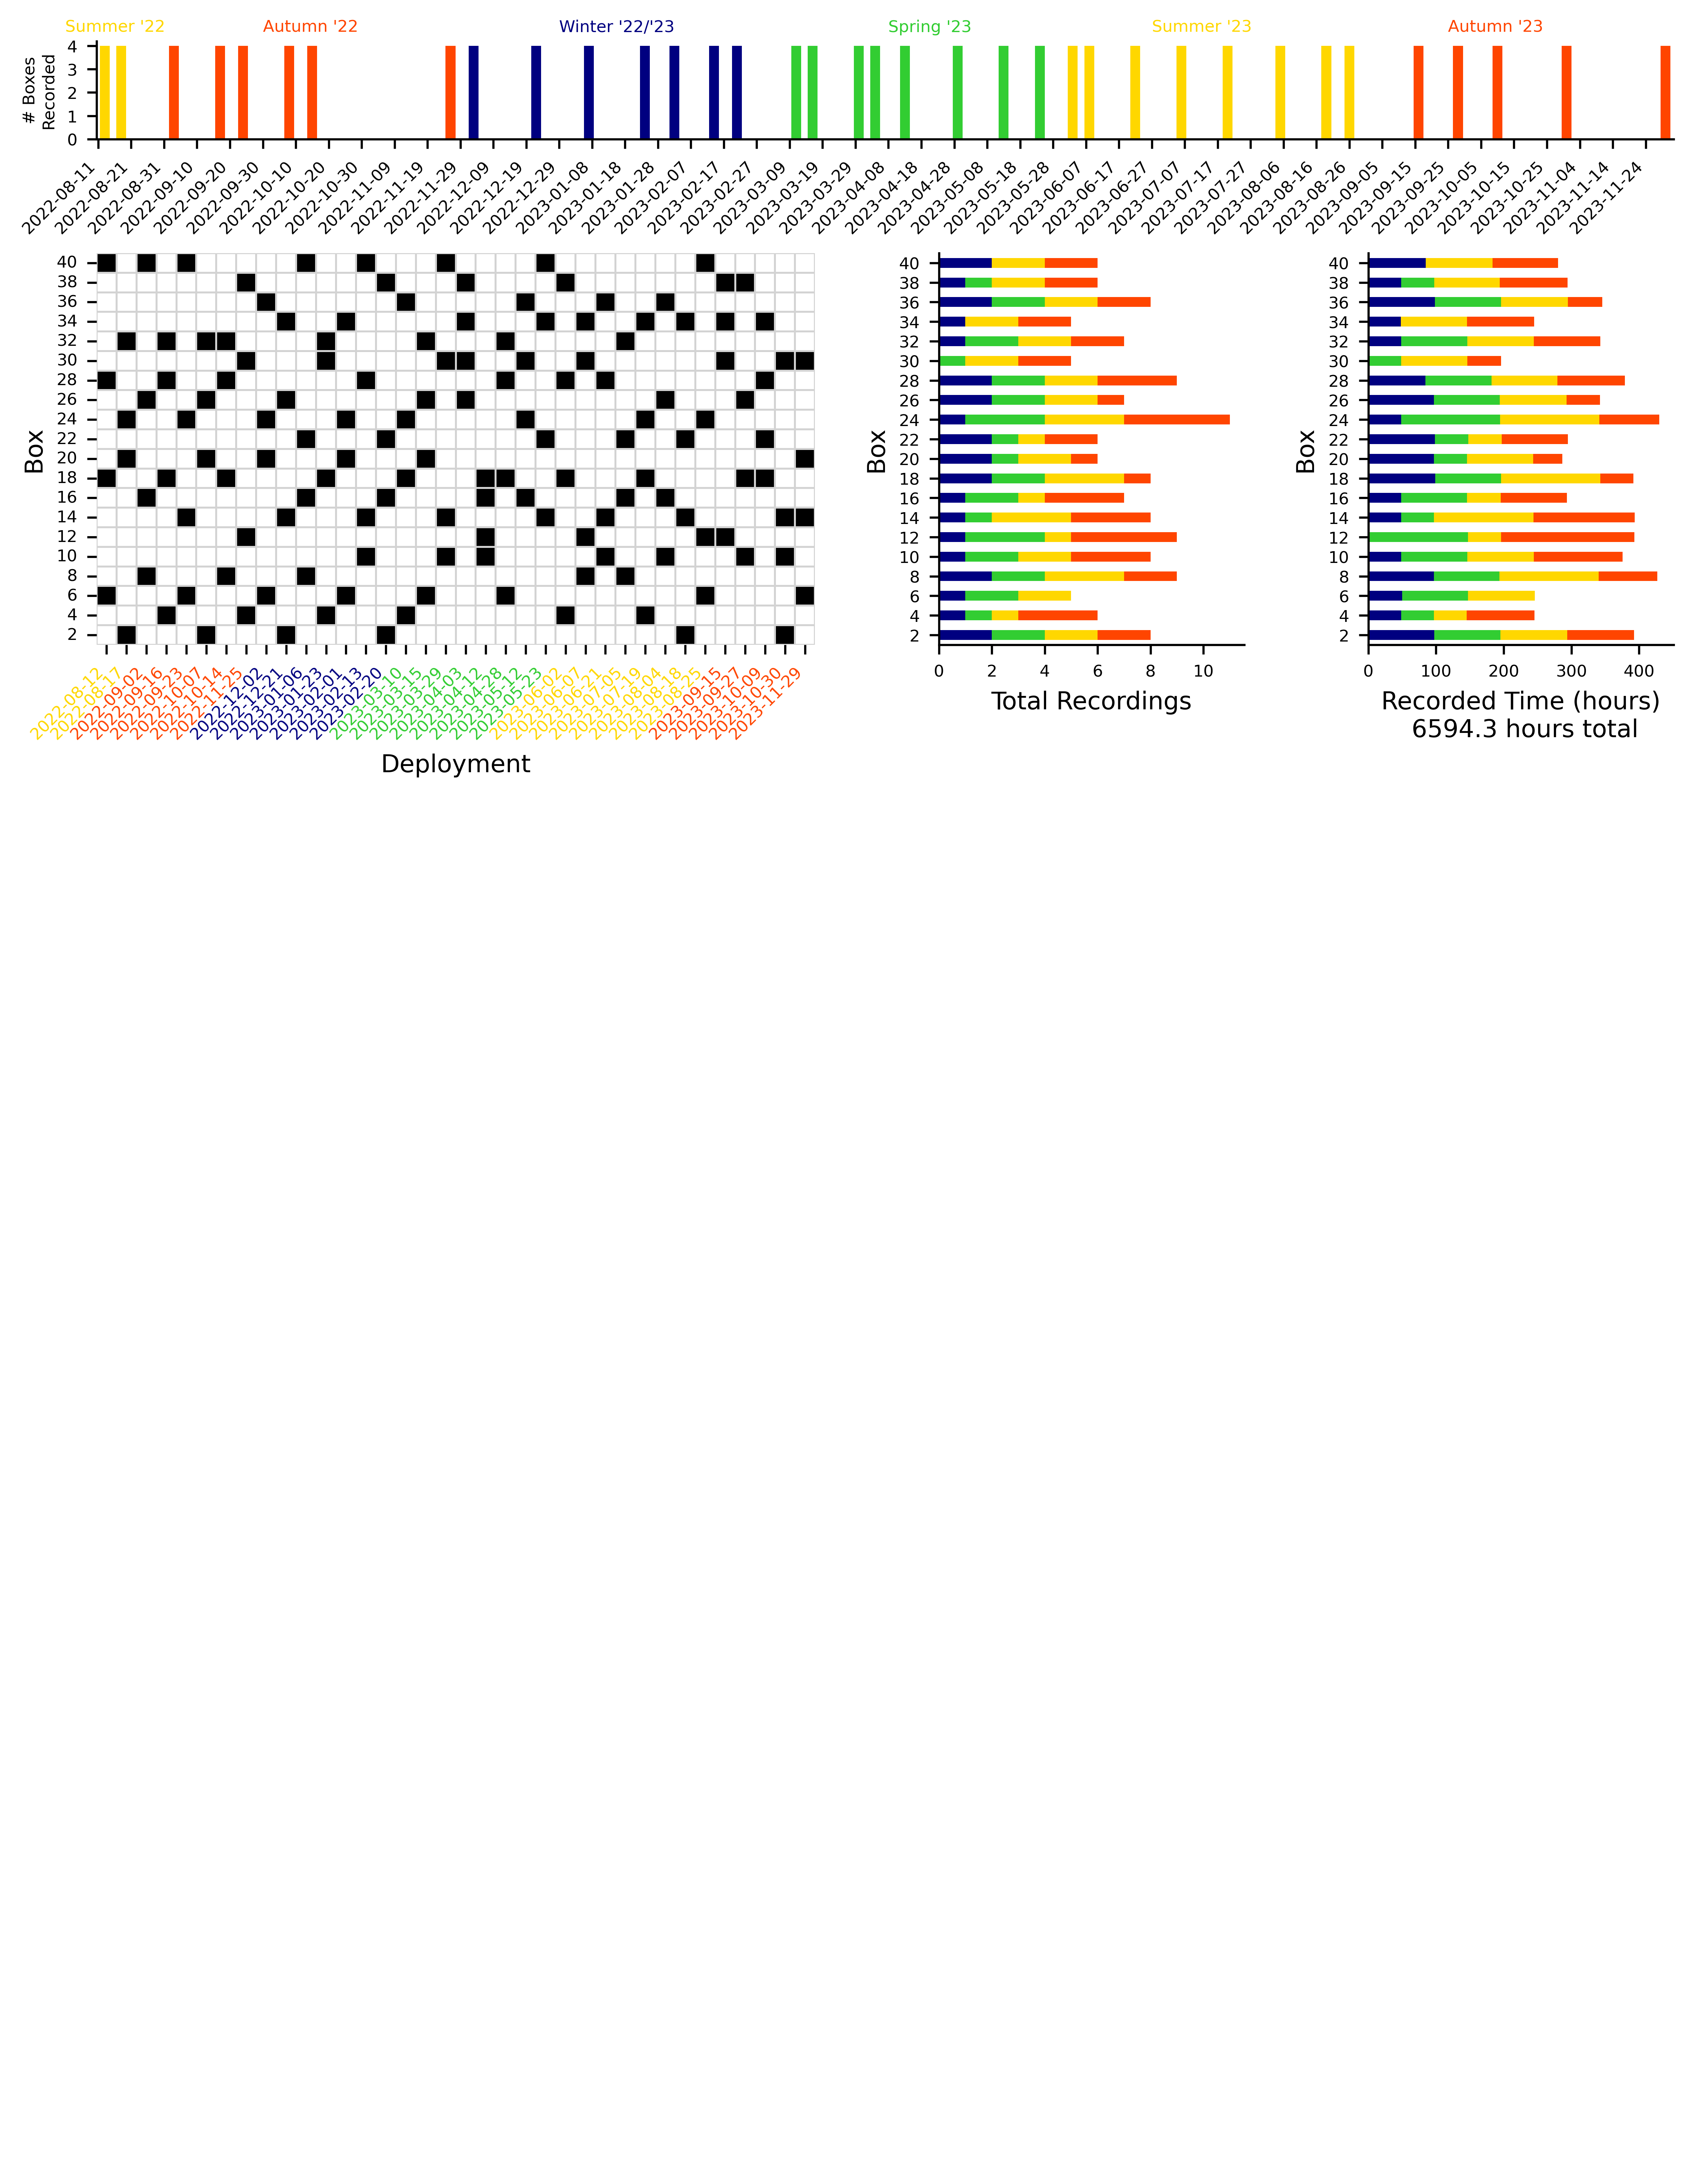

In [10]:
# save or not
save = False
path_to_save = ''

##################################################################################################

fig, axes = plt.subplot_mosaic(mosaic="AAAAAAAA;"\
                                      "BBBBCCDD;"\
                                      "BBBBCCDD;"\
                                      "00000000;"\
                                      "00000000;"\
                                      "00000000;"\
                                      "00000000;"\
                                      "00000000;"\
                                      "00000000;"\
                                      "00000000",
                               figsize=[8.5,11], 
                               constrained_layout=True,
                               gridspec_kw={"height_ratios": [0.5,1,1,1,1,1,1,1, 1, 1]},
                               dpi=600)

axes["0"].axis('off')

#plot parameters
tick_label_fontsize = 6
axis_label_fontsize = 9
title_label_fontsize = 12
num_ticks = 10 # for panel F x-axis
dot_size = 10
dot_alpha = .5
seasons_palette = prms.load_json(os.path.join(root, 'parameters', 'json_files','season_color_dict.json'))

##################################################################################################
# panel A - recordings by day of dataset
##################################################################################################

# Convert date columns to datetime
boxes_recorded_df['deployment_start'] = pd.to_datetime(boxes_recorded_df['deployment_start'])
boxes_recorded_df['deployment_end'] = pd.to_datetime(boxes_recorded_df['deployment_end'])

# Find the start and end dates
start_date = boxes_recorded_df['deployment_start'].min() - pd.Timedelta(days=1)
end_date = boxes_recorded_df['deployment_end'].max() + pd.Timedelta(days=1)

# Create a date range
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize a DataFrame to count the number of recordings per day
daily_counts = pd.DataFrame(index=date_range, columns=['count', 'season'])
daily_counts['count'] = 0
daily_counts['season'] = 'winter'  # Default season

# Count the number of audiomoths recorded each day and assign seasons
for _, row in boxes_recorded_df.iterrows():
    daily_counts.loc[row['deployment_start']:row['deployment_end'], 'count'] += 4
    daily_counts.loc[row['deployment_start']:row['deployment_end'], 'season'] = row['season']
    
# Plot bars manually with colors
for date in daily_counts.index:
    season = daily_counts.loc[date, 'season']
    color = seasons_palette.get(season, 'gray')  # Extract season (e.g., 'summer') and get color
    axes["A"].bar(date, daily_counts.loc[date, 'count'], width=1.0, color=color, align='center', edgecolor='none')

# Set the interval for x-ticks
n_days = 10  # Change this value to show a tick every n days
axes["A"].xaxis.set_major_locator(mdates.DayLocator(interval=n_days))
axes["A"].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes["A"].yaxis.set_major_locator(MaxNLocator(integer=True))

# Improve date formatting
axes["A"].set_xlabel('')
axes["A"].set_ylabel('# Boxes\nRecorded', fontsize=tick_label_fontsize)
axes["A"].tick_params(axis='x', rotation=45)

# Adjust x-axis limits and ticks
axes["A"].set_xlim(daily_counts.index[0] - pd.Timedelta(days=0.5), daily_counts.index[-1] + pd.Timedelta(days=0.5))
axes["A"].set_xticks(daily_counts.index[::n_days])  # Show a tick every n_days
axes["A"].set_xticklabels([date.strftime('%Y-%m-%d') for date in daily_counts.index[::n_days]], rotation=45, ha='right')
axes["A"].tick_params(which='both', labelsize=tick_label_fontsize)

# Add legend
text_y_position = daily_counts['count'].max() * 1.2  # Position the text at 90% of the max y value
text_x_position = daily_counts.index[0]- pd.Timedelta(days=10)  # Place the text at the start of the x-axis
for season in ['summer_22', 'autumn_22', 'winter', 'spring', 'summer_23', 'autumn_23']:
    
    color = seasons_palette[season]
    if season == 'summer_22':
        axes["A"].text(text_x_position, text_y_position, "Summer '22", color=color, fontsize=tick_label_fontsize, ha='left', va='center')
        text_x_position += pd.Timedelta(days=60)  # Shift position for the next label
    elif season == 'autumn_22':
        axes["A"].text(text_x_position, text_y_position, "Autumn '22", color=color, fontsize=tick_label_fontsize, ha='left', va='center')
        text_x_position += pd.Timedelta(days=90)  # Shift position for the next label
    elif season == 'winter':
        axes["A"].text(text_x_position, text_y_position, "Winter '22/'23", color=color, fontsize=tick_label_fontsize, ha='left', va='center')
        text_x_position += pd.Timedelta(days=100)  # Shift position for the next label
    elif season == 'spring':
        axes["A"].text(text_x_position, text_y_position, "Spring '23", color=color, fontsize=tick_label_fontsize, ha='left', va='center')
        text_x_position += pd.Timedelta(days=80)  # Shift position for the next label
    elif season == 'summer_23':
        axes["A"].text(text_x_position, text_y_position, "Summer '23", color=color, fontsize=tick_label_fontsize, ha='left', va='center')
        text_x_position += pd.Timedelta(days=90)  # Shift position for the next label
    elif season == 'autumn_23':
        axes["A"].text(text_x_position, text_y_position, "Autumn '23", color=color, fontsize=tick_label_fontsize, ha='left', va='center')
        
sns.despine(ax = axes["A"])


##################################################################################################
# panel B - heatmap of recordings per box per deployment
##################################################################################################

# organize the data
boxes_recorded_df['deployment_start'] = boxes_recorded_df['deployment_start'].astype(str)
melted_df = boxes_recorded_df.melt(id_vars=['deployment_start'], 
                                   value_vars=['audiomoth01', 'audiomoth02', 'audiomoth03', 'audiomoth04'], 
                                   var_name='audiomoth', 
                                   value_name='box')

heatmap_data = melted_df.pivot_table(index='box', columns='deployment_start', aggfunc='size', fill_value=0)
all_boxes = np.arange(2, 41)
heatmap_data = heatmap_data.reindex(all_boxes, fill_value=0)
heatmap_data = heatmap_data.drop([i for i in heatmap_data.index if i % 2 != 0])

# plot it

sns.heatmap(heatmap_data, 
            cmap='Greys', 
            cbar=False, 
            linewidths=0.5, 
            linecolor='lightgrey', ax = axes["B"])

axes["B"].set_xlabel('Deployment', fontsize = axis_label_fontsize)
axes["B"].set_ylabel('Box', fontsize = axis_label_fontsize)
axes["B"].tick_params(which = 'both', labelsize = tick_label_fontsize)
axes["B"].set_xticklabels(axes["B"].get_xticklabels(), rotation=90, ha="center")
axes["B"].set_yticklabels(axes["B"].get_yticklabels(), rotation=0)
axes["B"].set_xticks(np.arange(len(heatmap_data.columns)) + 0.5)
axes["B"].set_xticklabels(heatmap_data.columns, rotation=45, ha="right")
axes["B"].set_yticks(np.arange(len(heatmap_data.index)) + 0.5)
axes["B"].set_yticklabels(heatmap_data.index, rotation=0)

# Color the x-tick labels
xtick_labels = axes["B"].get_xticklabels()
xtick_labels_text = [label.get_text() for label in xtick_labels]
xtick_colors = [seasons_palette[deployment_seasons_dict.get(label)] for label in xtick_labels_text]

# reverse the yticks to align with bar plots
ytick_positions = np.arange(len(heatmap_data.index)) + 0.5
ytick_labels = list(heatmap_data.index)[::-1]  # Reverse the labels to start from the top
axes["B"].set_yticks(ytick_positions)
axes["B"].set_yticklabels(ytick_labels, rotation=0)

for label, color in zip(xtick_labels, xtick_colors):
    label.set_color(color)

##################################################################################################
# panel C - barplot of number of recordings
##################################################################################################


melted_df = boxes_recorded_df.melt(id_vars=['deployment_start', 'season'],
                                   value_vars=['audiomoth01', 'audiomoth02', 'audiomoth03', 'audiomoth04'],
                                   var_name='audiomoth',
                                   value_name='box')
melted_df['box'] = melted_df['box'].astype(int)
aggregated_df = melted_df.groupby(['box', 'season']).size().unstack(fill_value=0)
aggregated_df = aggregated_df.sort_values(by = 'box', ascending = True)
aggregated_df = aggregated_df.reindex(columns=['winter', 'spring', 'summer_22', 'summer_23', 'autumn_22', 'autumn_23'], fill_value = 0)

# Create the horizontal stacked bar plot
aggregated_df.plot(kind='barh', 
                   stacked=True,
                   ax=axes["C"], 
                   color=[seasons_palette[col] for col in aggregated_df.columns])

# dd labels and title
axes["C"].set_xlabel('Total Recordings', fontsize = axis_label_fontsize)
axes["C"].set_ylabel('Box', fontsize = axis_label_fontsize)
axes["C"].get_legend().remove()
axes["C"].tick_params(which = 'both', labelsize = tick_label_fontsize)
sns.despine(ax = axes["C"])

##################################################################################################
# panel C - barplot of total recording time
##################################################################################################

# Melt the dataframe
aggregated_df = recording_durations_df.groupby(['box', 'season'])['recording_duration_hours'].sum().unstack(fill_value=0)
aggregated_df = aggregated_df.reindex(columns=['winter', 'spring', 'summer_22', 'summer_23', 'autumn_22', 'autumn_23'], fill_value=0)
aggregated_df = aggregated_df.sort_index()  
aggregated_df.plot(kind='barh', 
                   stacked=True,
                   ax=axes["D"], 
                   color=[seasons_palette[col] for col in ['winter', 'spring', 'summer_22', 'summer_23', 'autumn_22', 'autumn_23']])
# Get total length of raw audio dataset in hours
total_hours = recording_durations_df['recording_duration_hours'].sum()

# Add labels and title
axes["D"].set_xlabel('Recorded Time (hours)\n '+ str(np.round(total_hours,1)) +" hours total", fontsize=axis_label_fontsize)
axes["D"].set_ylabel('Box', fontsize = axis_label_fontsize)
axes["D"].get_legend().remove()  # Remove the legend
axes["D"].tick_params(which='both', labelsize=tick_label_fontsize)
axes["D"].set_yticks(np.arange(len(aggregated_df.index)))
axes["D"].set_yticklabels(aggregated_df.index, rotation=0)
sns.despine(ax = axes["D"])

if save:
    plt.savefig(os.path.join(path_to_save, 'Supplemental_Figure_1_.jpeg'), dpi = 600)
    plt.savefig(os.path.join(path_to_save, 'Supplemental_Figure_1.svg'), dpi = 600)
    